# 6.6 Time Series


### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the data

## 1. Importing your libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles  statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or feature.

plt.style.use('fivethirtyeight') # This is a styling option for how our plots will appear.

In [2]:
# define path
path = r'/Users/yusufsalk/Documents/Chocolate Bar Analysis'

In [3]:
#import data
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'chocolate_bar.pkl'))

In [4]:
df.shape

(1795, 8)

In [5]:
df.head()

,company_name,specific_bean_origin,ref,review_date,cocoa_percentage,company_location,rating,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,Peru


In [6]:
type(df)

pandas.core.frame.DataFrame

## 2. Subsetting, wrangling, and cleaning time-series data

In [7]:
# drop the unnecessary columns
df = df.drop(columns = ['company_name', 'specific_bean_origin', 'ref', 'cocoa_percentage', 'company_location', 'broad_bean_origin'])

In [8]:
df.head()

,review_date,rating
0,2016,3.75
1,2015,2.75
2,2015,3.00
3,2015,3.50
4,2015,3.50


In [9]:
df['review_date']

0       2016
1       2015
2       2015
3       2015
4       2015
        ... 
1790    2011
1791    2011
1792    2011
1793    2011
1794    2010
Name: review_date, Length: 1795, dtype: int64

In [10]:
# create a subset with values of the mean of ratings by year
df_sub = df.groupby('review_date')['rating'].mean().rename('mean_rating').reset_index()

In [11]:
df_sub

,review_date,mean_rating
0,2006,3.125000
1,2007,3.162338
2,2008,2.994624
3,2009,3.073171
4,2010,3.148649
5,2011,3.256061
6,2012,3.178205
7,2013,3.197011
8,2014,3.189271
9,2015,3.246491


By looking at the averages of the ratings given by the years in which the reviews were made, we can analyze the change of these values over time.

In [12]:
# convert the review_date column to datetime year format
df_sub['review_date'] = pd.to_datetime(df_sub['review_date'], format='%Y')

In [13]:
df_sub.head()

,review_date,mean_rating
0,2006-01-01,3.125000
1,2007-01-01,3.162338
2,2008-01-01,2.994624
3,2009-01-01,3.073171
4,2010-01-01,3.148649


In [14]:
# Set the "review_date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['review_date']) # Create a datetime column from "review_date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['review_date'], axis=1, inplace=True) # Drop the "review_date" column.
df_sub.head()

,mean_rating
datetime,
2006-01-01,3.125000
2007-01-01,3.162338
2008-01-01,2.994624
2009-01-01,3.073171
2010-01-01,3.148649


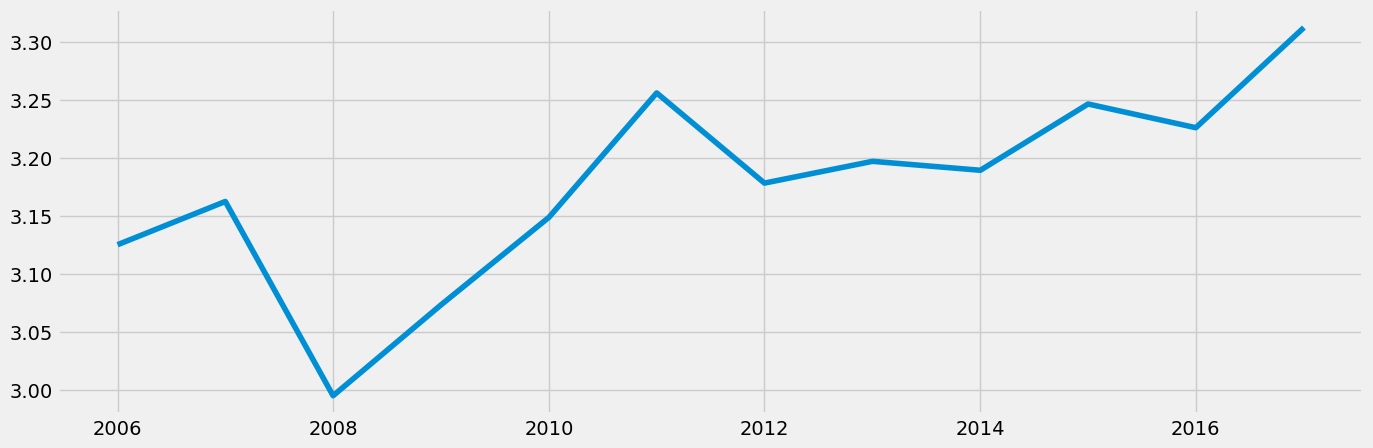

In [15]:
# plot the new subset

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [16]:
# check for missing values
df_sub.isnull().sum() 

mean_rating    0
dtype: int64

In [17]:
# check for duplicates
dups = df_sub.duplicated()
dups.sum()

0

## 3. Time-series analysis: decomposition

In [18]:
# decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

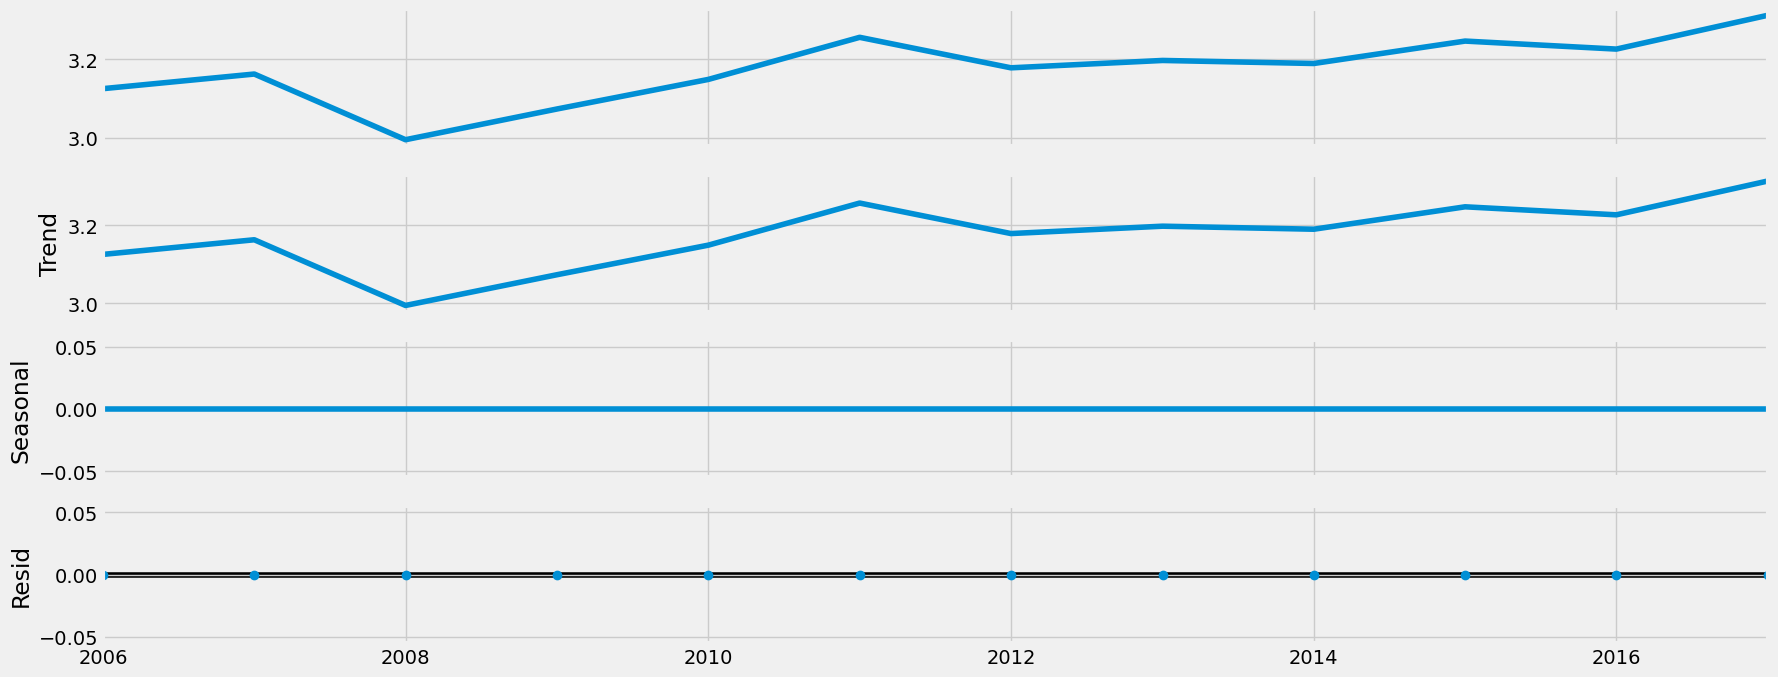

In [20]:
# plot the separate components
decomposition.plot()
plt.show()

The level and trend appear the same, so it can be said that the data doesn’t have much noise (and, thus, doesn’t need to be smoothed).

Looking at the trend in the chart above, while there was a sharp decrease in 2008 and a little drop in 2012, and excluding some minor fluctuations afterward, there is an increase in chocolate bar quality in general.

Additionally, there is neither seasonality nor noise in the data since the lines in chart are flat.

## 4. Testing for stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['mean_rating'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.237766
p-value                        0.657142
Number of Lags Used            3.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


If we’re using a significance level of 5 percent, we’d need to look at the “Critical Value (5%)” in the results, which, in this case, has a value of -3.367187. This is smaller than the test statistic, which is -1.237766, which means that we can’t reject the null hypothesis. This means that there is a unit root in the data, and the data is non-stationary.

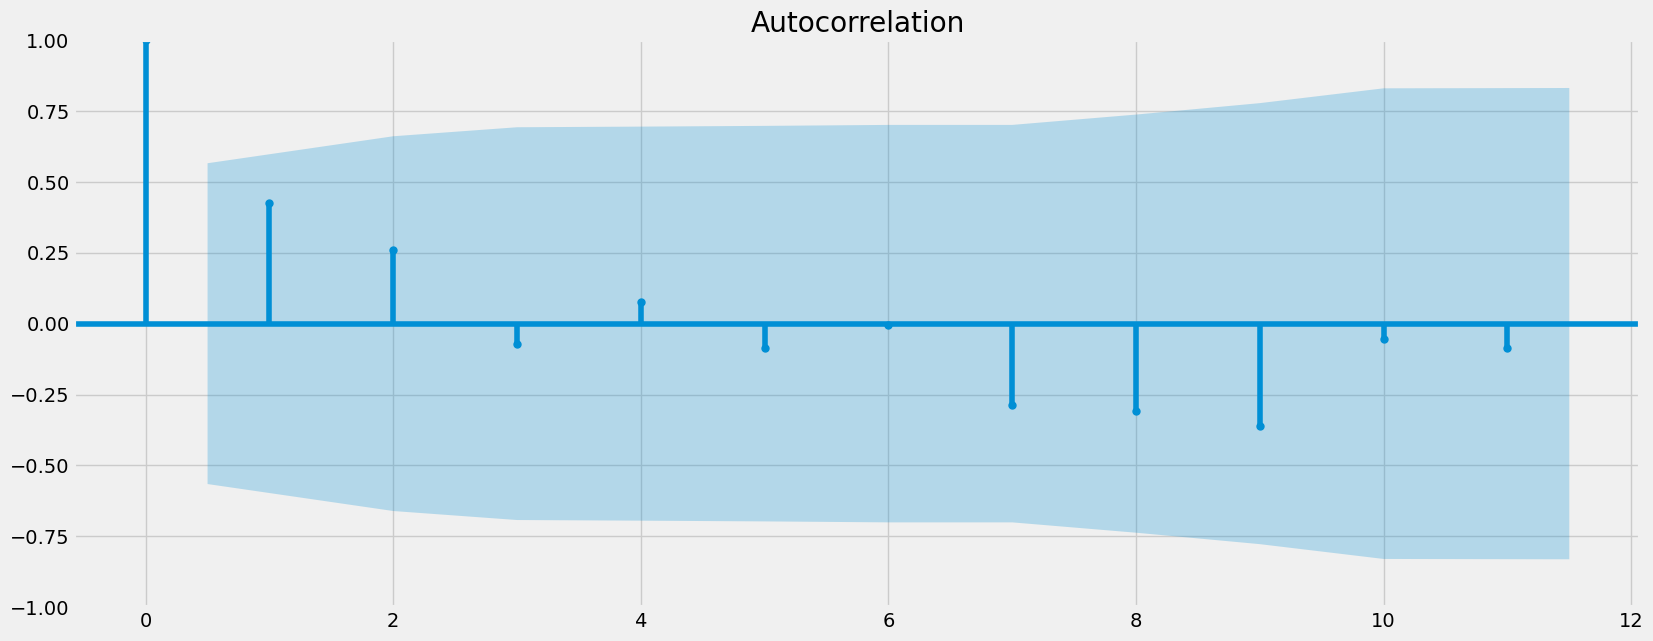

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, we import the autocorrelation and partial correlation plots

plot_acf(df_sub)
plt.show()

## 5. Stationarizing the data

In [23]:
data_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, we remove the missing values that came about as a result of the differencing. 
# We need to remove these or we won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,mean_rating
datetime,
2007-01-01,0.037338
2008-01-01,-0.167714
2009-01-01,0.078547
2010-01-01,0.075478
2011-01-01,0.107412


In [26]:
data_diff.columns

Index(['mean_rating'], dtype='object')

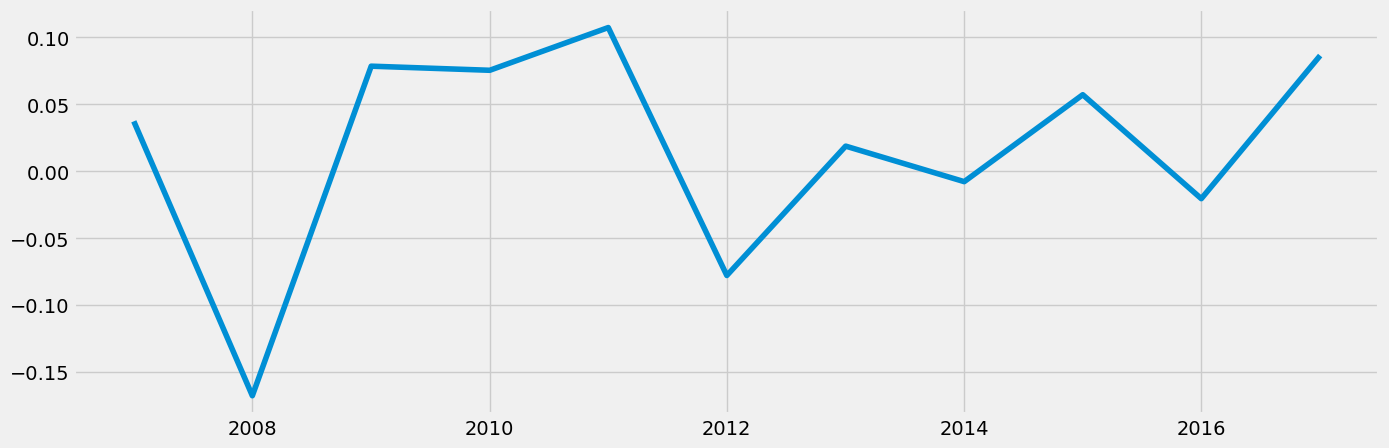

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -5.667874e+00
p-value                        9.063533e-07
Number of Lags Used            2.000000e+00
Number of Observations Used    8.000000e+00
Critical Value (1%)           -4.665186e+00
Critical Value (5%)           -3.367187e+00
Critical Value (10%)          -2.802961e+00
dtype: float64


The test statistic above, is smaller than the critical value at both the five and ten percent significance levels. The p-value is also much smaller than 0.05. This means we can reject the null hypothesis and consider the series stationary.

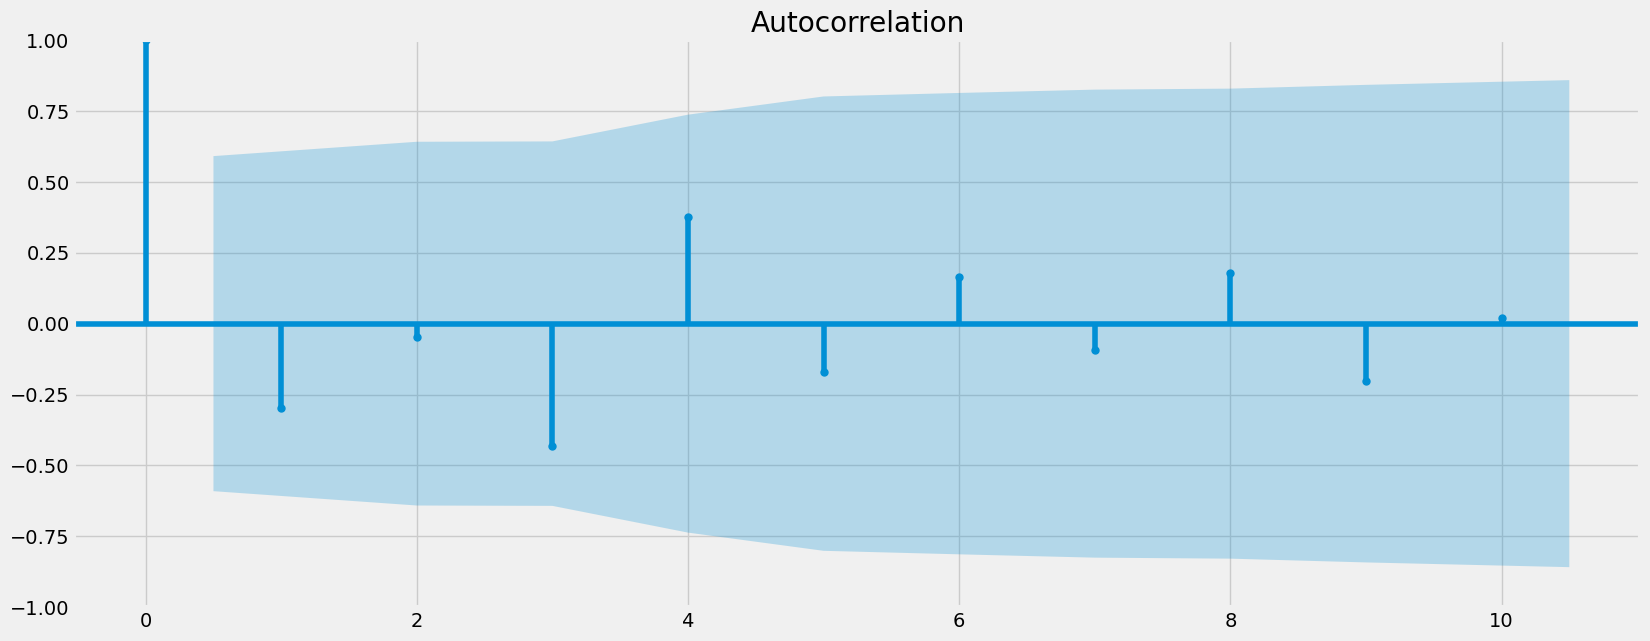

In [29]:
plot_acf(data_diff)
plt.show()

To conduct another round of differencing to stationarize it further and reduce the remaining autocorrelated terms, we need at least ten significant lags (or ten vertical lines above the confidence interval) as a rule of thumb. However, this is not in the chart above.